# Challenges of Expedia
## Chen Ximing 19433093

### Description 

Planning your dream vacation, or even a weekend escape, can be an overwhelming affair. With hundreds, even thousands, of hotels to choose from at every destination, it's difficult to know which will suit your personal preferences. Should you go with an old standby with those pillow mints you like, or risk a new hotel with a trendy pool bar? 
 
Expedia wants to take the proverbial rabbit hole out of hotel search by providing personalized hotel recommendations to their users. This is no small task for a site with hundreds of millions of visitors every month!

Currently, Expedia uses search parameters to adjust their hotel recommendations, but there aren't enough customer specific data to personalize them for each user. In this competition, Expedia is challenging Kagglers to contextualize customer data and predict the likelihood a user will stay at 100 different hotel groups.
The data in this competition is a random selection from Expedia and is not representative of the overall statistics. 

https://www.kaggle.com/c/expedia-hotel-recommendations


In [81]:
review = pd.read_csv('destinations.csv')
print(len(review))
review.head()

62106


,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [6]:
import datetime
import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

Read csv file

In [13]:
TRAIN = 'C:\\Users\\81074\\Desktop\\train_hotel.csv'
TEST = 'C:\\Users\\81074\\Desktop\\test_hotel.csv'
Y = 'C:\\Users\\81074\\Desktop\\y.csv'

In [14]:
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

def load_preprocessed_dfs(drop_full_visitor_id=True):
    """
    Loads files `TRAIN`, `TEST` and `Y` generated by preprocess() into variables
    """
    X_train = pd.read_csv(TRAIN, converters={'is_booking': int})
    X_test = pd.read_csv(TEST, converters={'is_booking': int})
    y_train = pd.read_csv(Y, names=['hotel_cluster']).T.squeeze()
    
    # Since it is the only `object` column, drop it for better training and evaluating
    if drop_full_visitor_id: 
        X_train = X_train.drop(['is_booking'], axis=1)
        X_test = X_test.drop(['is_booking'], axis=1)
    return X_train, y_train, X_test

In [16]:
X, y, X_test = load_preprocessed_dfs()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, random_state=1)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test (submit) shape: {X_test.shape}")

Train shape: (738337, 23)
Validation shape: (15069, 23)
Test (submit) shape: (75341, 23)


LightGB

In [17]:
def run_lgb(X_train, y_train, X_val, y_val, X_test):
    
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 1,
        "verbosity" : -1,
        "seed": 1
    }
    
    lgb_train_data = lgb.Dataset(X_train, label=y_train)
    lgb_val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params, lgb_train_data, 
                      num_boost_round=5000,
                      valid_sets=[lgb_train_data, lgb_val_data],
                      early_stopping_rounds=100,
                      verbose_eval=500)

    y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_submit = model.predict(X_test, num_iteration=model.best_iteration)

    print(f"LGBM: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model, y_pred_train

In [18]:
X_train['date_time'] = pd.to_datetime(X_train['date_time'])
X_train.set_index("date_time", inplace=True)
X_train['srch_ci'] = pd.to_datetime(X_train['srch_ci'])
X_train.set_index("srch_ci", inplace=True)
X_train['srch_co'] = pd.to_datetime(X_train['srch_co'])
X_train.set_index("srch_co", inplace=True)

C:\Users\81074\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\81074\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\81074\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [19]:
X_test['date_time'] = pd.to_datetime(X_test['date_time'])
X_test.set_index("date_time", inplace=True)
X_test['srch_ci'] = pd.to_datetime(X_test['srch_ci'])
X_test.set_index("srch_ci", inplace=True)
X_test['srch_co'] = pd.to_datetime(X_test['srch_co'])
X_test.set_index("srch_co", inplace=True)

In [20]:
X_val['date_time'] = pd.to_datetime(X_val['date_time'])
X_val.set_index("date_time", inplace=True)
X_val['srch_ci'] = pd.to_datetime(X_val['srch_ci'])
X_val.set_index("srch_ci", inplace=True)
X_val['srch_co'] = pd.to_datetime(X_val['srch_co'])
X_val.set_index("srch_co", inplace=True)

C:\Users\81074\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\81074\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\81074\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [21]:
lgb_preds,lgb_model,lgb_preds_train = run_lgb(X_train, y_train, X_val, y_val, X_test)

Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.262938	valid_1's rmse: 0.263741
[1000]	training's rmse: 0.261834	valid_1's rmse: 0.26272
[1500]	training's rmse: 0.261328	valid_1's rmse: 0.26245
[2000]	training's rmse: 0.260975	valid_1's rmse: 0.262354
[2500]	training's rmse: 0.260628	valid_1's rmse: 0.26227
[3000]	training's rmse: 0.260299	valid_1's rmse: 0.262203
[3500]	training's rmse: 0.259976	valid_1's rmse: 0.262132
[4000]	training's rmse: 0.259669	valid_1's rmse: 0.26208
Early stopping, best iteration is:
[4381]	training's rmse: 0.25944	valid_1's rmse: 0.262047
LGBM: RMSE val: 0.26205  - RMSE train: 0.25944


XGBoost

In [22]:
def run_xgb(X_train, y_train, X_val, y_val, X_test):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 1,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train, y_train)
    xgb_val_data = xgb.DMatrix(X_val, y_val)
    xgb_submit_data = xgb.DMatrix(X_test)

    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=200, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    print(f"XGB : RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model ,y_pred_train

In [23]:
xgb_preds, xgb_model ,xgb_pred_training = run_xgb(X_train, y_train, X_val, y_val, X_test)

[0]	train-rmse:0.49977	valid-rmse:0.49964
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[199]	train-rmse:0.43662	valid-rmse:0.43680
XGB : RMSE val: 0.4368  - RMSE train: 0.43662


CatBoost

In [24]:
def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 1,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=True)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_submit = model.predict(X_test)

    print(f"CatB: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model , y_pred_train

In [25]:
# For train catboost and generated predictions
cat_preds, cat_model ,cat_preds_train= run_catboost(X_train, y_train, X_val, y_val,  X_test)

0:	learn: 0.2699672	test: 0.2712010	best: 0.2712010 (0)	total: 390ms	remaining: 6m 29s
50:	learn: 0.2630480	test: 0.2638347	best: 0.2638347 (50)	total: 15.6s	remaining: 4m 49s
100:	learn: 0.2622677	test: 0.2631047	best: 0.2631047 (100)	total: 27.9s	remaining: 4m 8s
150:	learn: 0.2617663	test: 0.2628342	best: 0.2628342 (150)	total: 41.3s	remaining: 3m 52s
200:	learn: 0.2613354	test: 0.2626871	best: 0.2626871 (200)	total: 55s	remaining: 3m 38s
250:	learn: 0.2609543	test: 0.2625583	best: 0.2625583 (250)	total: 1m 8s	remaining: 3m 24s
300:	learn: 0.2605767	test: 0.2623906	best: 0.2623906 (300)	total: 1m 22s	remaining: 3m 11s
350:	learn: 0.2602286	test: 0.2622778	best: 0.2622778 (350)	total: 1m 36s	remaining: 2m 58s
400:	learn: 0.2598832	test: 0.2622154	best: 0.2622154 (400)	total: 1m 50s	remaining: 2m 45s
450:	learn: 0.2595607	test: 0.2621698	best: 0.2621594 (443)	total: 2m 5s	remaining: 2m 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2621593627
bestIteration = 4

In [26]:
df = pd.DataFrame({'Y':y_train,'Lightgbm':lgb_preds_train,'Xgboost':xgb_pred_training,'Catboost':cat_preds_train})
df.iloc[1:10,[0]]

,Y
589927,0
60890,0
147522,0
215447,0
705684,0
703552,0
308585,0
104918,1
746958,0


In [27]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,[1,2,3]], df.iloc[:,[0]], test_size=0.15, random_state=1)
lmodel = LinearRegression()
lmodel.fit(X_train,y_train)
y_pred_train = lmodel.predict(X_train)
y_pred = lmodel.predict(X_test)
print(f'RMSE Train :{rmse(y_train,y_pred_train)},RMSE Test:{rmse(y_test,y_pred)}')
print('The regression funtion is:Revenue = {:.3f} + {:.3f} * Lightgbm + {:.3f} * Xgboost + {:.3f} * Catboost'.format(lmodel.intercept_[0],lmodel.coef_[0,0],lmodel.coef_[0,1],lmodel.coef_[0,2]))

RMSE Train :0.25883,RMSE Test:0.26015
The regression funtion is:Revenue = 0.472 + 1.072 * Lightgbm + -1.182 * Xgboost + 0.284 * Catboost


In [28]:
print("LightGBM features importance...")
gain = lgb_model.feature_importance('gain')
featureimp = pd.DataFrame({'feature': lgb_model.feature_name(), 
                   'split': lgb_model.feature_importance('split'), 
                   'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:3])

LightGBM features importance...
                feature  split       gain
15                  cnt   4999  32.590270
10      srch_adults_cnt   5358  11.021860
13  srch_destination_id  19001   7.513928


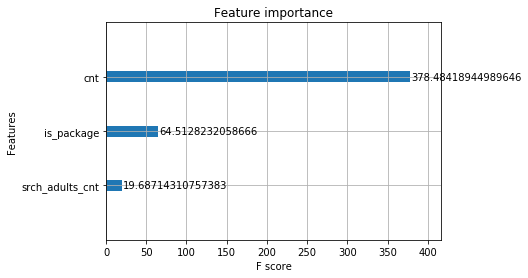

In [29]:
xgb.plot_importance(xgb_model,max_num_features=3,importance_type='gain')

In [53]:
print("Catboost Model features importance...")
gain = cat_model.feature_importances_
featureimp = pd.DataFrame({'feature': cat_model.feature_names_, 
                   'split': cat_model.feature_importances_, 
                   'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:3])

Catboost Model features importance...
            feature      split       gain
15              cnt  23.849922  23.849922
10  srch_adults_cnt  10.805794  10.805794
19    hotel_cluster   8.075593   8.075593


cnt is most important feature

In [68]:
import pymc3 as pm

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    P = pm.Uniform('p', lower=0, upper=1)

There are no stronger beliefs expressed in the prior distribution.

In [69]:
import scipy.stats as stats
#set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
80


The observed frequency is:

In [70]:
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency that sets p_true = 0.05? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0533
Does this equal the true frequency that sets p_true = 0.05? False


We combine the observations into the PyMC3 observed variable, and run our inference algorithm:

In [71]:
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", P, observed=occurrences)
    step = pm.Metropolis()
    trace = pm.sample(1800, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 9200/9200 [01:03<00:00, 144.22draws/s]
The number of effective samples is smaller than 25% for some parameters.


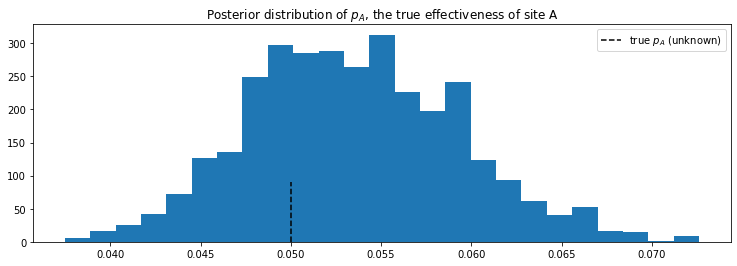

In [72]:
from IPython.core.pylabtools import figsize
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled")
plt.legend();

In [73]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.06

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 5000
N_B = 4000

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")
count = [sum(observations_B), sum(observations_A)]
print(count)

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] ...
[249, 251]


In [74]:
print(f"Conversion rate in Site A version =", np.mean(observations_A))
print(f"Conversion rate in Site B version =", np.mean(observations_B))

Conversion rate in Site A version = 0.0502
Conversion rate in Site B version = 0.06225


In [75]:
import statsmodels.api as sm
stat, pval = sm.stats.proportions_ztest(count, [N_B,N_A], alternative='larger')
print(f"P-Value under classical ABTest =",pval)

P-Value under classical ABTest = 0.006571523008114408


In [76]:
from statsmodels.stats.power import TTestIndPower
effect = 0.01
alpha = 0.025
power = 0.7
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print("Minimum sample size with 2.5% sig level & 70% power test =", round(result))

Minimum sample size with 2.5% sig level & 70% power test = 152995


In [77]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(5500, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████| 24000/24000 [25:41<00:00, 15.57draws/s]
The number of effective samples is smaller than 10% for some parameters.


Below we plot the posterior distributions for the three unknowns:

In [78]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

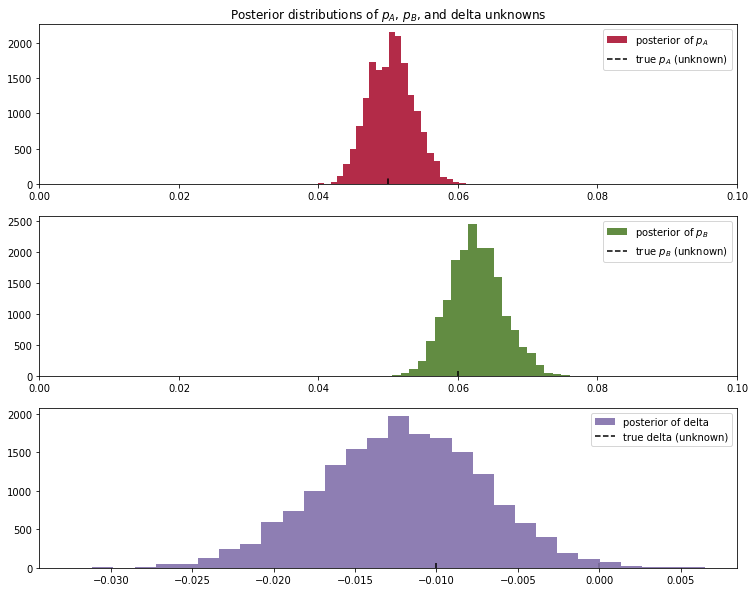

In [79]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628")
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821")
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6")
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [80]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.993
Probability site A is BETTER than site B: 0.007
